## AdamW/SGDW benchmarking

This is to benchmark an implementation of https://arxiv.org/abs/1711.05101

In [1]:
PATH = 'data/cifar10/'

In [8]:
!ls {PATH}

labels.txt  train  valid


In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import matplotlib.pyplot as plt
%matplotlib inline

### Common stuff for all experiments

In [4]:
def Get_SGD_Momentum(momentum=0.9):
    return lambda *args, **kwargs: optim.SGD(*args, momentum=momentum, **kwargs)

def Get_Adam():
    return lambda *args, **kwargs: optim.Adam(*args, **kwargs)

In [5]:
import pickle

def save_list(fname, l):
    with open(fname, "wb") as fp:
        pickle.dump(l, fp)
        
def read_list(fname):
    with open(fname, "rb") as fp:
        return pickle.load(fp)

### Section 1: Plot loss trends of various scenarios

### This is a common function which does the training. 

The only thing it asks for is the optimizer, and the initial LR for that optimizer. Hence we are comparing optimizers keeping all things same.

In [6]:
def experiment(optimizer, PATH, lr=1e-3, find_lr=False, use_wd_sched=False, wds=None, do_unfreeze=False):
    sz = 32
    bs = 120
    arch=resnet152
    cycle_len=2
    cycle_mult=2
    num_cycles = 4
    lr = lr
    
    if wds is None:
        weight_decay = 0.025 # As used in the paper https://arxiv.org/abs/1711.05101
    else:
        weight_decay = wds
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    learn = ConvLearner.pretrained(arch, data, precompute=True, xtra_fc=[1024, 512], opt_fn=optimizer)
    
    if find_lr:
        lrf=learn.lr_find()
        learn.sched.plot()
        return
    
    learn.fit(lr, 1, wds=weight_decay, use_wd_sched=use_wd_sched)
    print('Now with precompute as False')
    if do_unfreeze:
        learn.unfreeze()
        
    learn.precompute=False
    learn.fit(lr, num_cycles, wds=weight_decay, use_wd_sched=use_wd_sched, cycle_len=cycle_len, cycle_mult=cycle_mult)
    
    loss = learn.sched.losses
    fig = plt.figure(figsize=(10, 5))
    plt.plot(loss)
    plt.show()
    learn.sched.plot_lr()
    
    return learn.sched.losses

### SGDR/SGDW

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/nbuser/.torch/models/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 81335554.74it/s]


100%|██████████| 84/84 [04:04<00:00,  2.91s/it]


HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▊ | 370/417 [00:47<00:05,  7.87it/s, loss=6.72]CPU times: user 1min 42s, sys: 34.5 s, total: 2min 16s
Wall time: 27min 10s


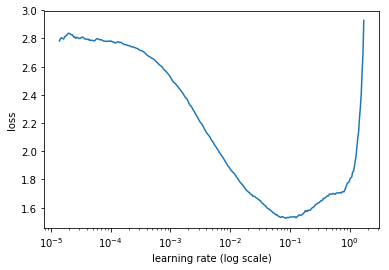

 89%|████████▊ | 370/417 [01:00<00:07,  6.16it/s, loss=6.72]

In [9]:
%%time
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, find_lr=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))


  4%|▍         | 17/417 [00:02<00:58,  6.82it/s, loss=2.03]
                                                            [A


Exception in thread Thread-8:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
Exception in thread Thread-7:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




[ 0.       1.1004   1.04837  0.65129]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.15065  1.01776  0.65903]                       
[ 1.       1.10755  0.974    0.66796]                       
[ 2.       1.18711  1.05032  0.65446]                       
[ 3.       1.15496  1.03364  0.65764]                       
[ 4.       1.09809  0.98204  0.67887]                       
[ 5.       1.06025  0.96013  0.68591]                       
[ 6.       1.18615  1.08848  0.637  ]                       
[ 7.       1.20112  1.06111  0.65208]                       
[ 8.       1.18219  1.05174  0.64425]                       
[ 9.       1.16942  1.04908  0.64782]                       
[ 10.        1.13845   1.03011   0.65625]                   
[ 11.        1.10703   1.00002   0.66796]                   
[ 12.        1.08534   0.96421   0.68244]                   
[ 13.        1.05891   0.96302   0.68393]                   
[ 14.        1.22932   1.09649   0.63571]                   
[ 15.        1.22616   1.08295   0.63462]                   
[ 16.        1.22416   1

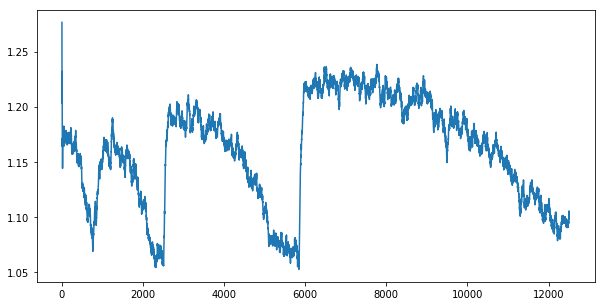

CPU times: user 42min 40s, sys: 10min 43s, total: 53min 24s
Wall time: 1h 19min 34s


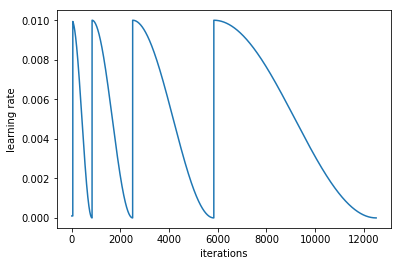

In [10]:
%%time
# Without weight decay
sgdm = Get_SGD_Momentum()
loss_sgdm = experiment(sgdm, PATH=PATH, lr=1e-2)
save_list('sgdm_loss.txt', loss_sgdm)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.10732  0.9878   0.65119]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.11071  0.95564  0.6623 ]                       
[ 1.       1.07562  0.93639  0.67183]                       
[ 2.       1.08     0.93505  0.67559]                       
[ 3.       1.05356  0.9116   0.67966]                       
[ 4.       1.01059  0.89143  0.6879 ]                        
[ 5.       0.9707   0.88257  0.69077]                        
[ 6.       1.04121  0.91081  0.67748]                       
[ 7.       1.03973  0.90991  0.68155]                       
[ 8.       1.01178  0.8818   0.69544]                        
[ 9.       0.98138  0.86406  0.69802]                        
[ 10.        0.95055   0.85367   0.70327]                    
[ 11.        0.93438   0.83591   0.70903]                    
[ 12.        0.90024   0.82953   0.7122 ]                    
[ 13.        0.88474   0.82644   0.70992]                    
[ 14.        1.02057   0.88207   0.69206]                    
[ 15.        0.98986   0.87744   0.69018]                    
[ 16.        0

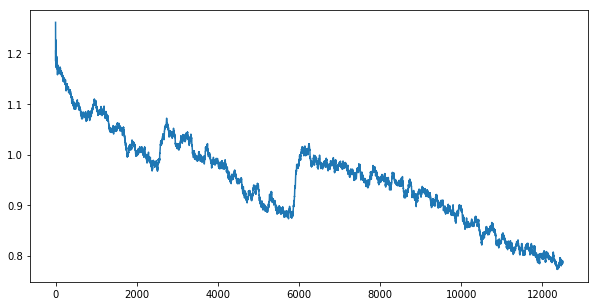

CPU times: user 43min 31s, sys: 10min 52s, total: 54min 23s
Wall time: 1h 18min 22s


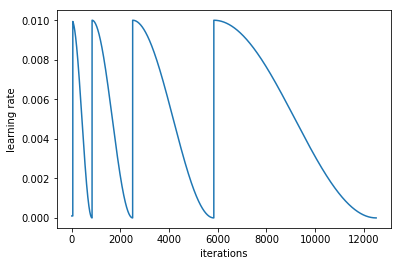

In [11]:
%%time
# With weight decay
sgdmw = Get_SGD_Momentum()
loss_sgdmw = experiment(sgdmw, PATH=PATH, lr=1e-2, use_wd_sched=True)
save_list('sgdmw_loss.txt', loss_sgdmw)

### Adam/AdamW

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 308/417 [00:33<00:11,  9.30it/s, loss=5.55]

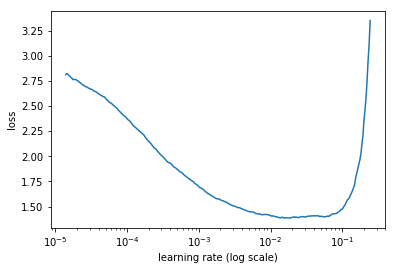

In [12]:
adam = Get_Adam()
loss_adam = experiment(adam, PATH, find_lr=True)

**Train**

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))


  0%|          | 0/417 [00:00<?, ?it/s]


Exception in thread Thread-73:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

Exception in thread Thread-74:
Traceback (most recent call last):
  File "/usr/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/usr/local/lib/python3.6/dist-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/usr/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[ 0.       1.16107  1.11132  0.6127 ]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.25205  1.11456  0.62877]                       
[ 1.       1.18313  1.03365  0.65397]                       
[ 2.       1.28745  1.16212  0.61042]                       
[ 3.       1.2479   1.10954  0.6373 ]                       
[ 4.       1.19485  1.03201  0.65923]                       
[ 5.       1.14792  1.01189  0.66637]                       
[ 6.       1.25524  1.14045  0.61319]                       
[ 7.       1.25888  1.10603  0.63016]                       
[ 8.       1.24859  1.11626  0.62818]                       
[ 9.       1.21877  1.07533  0.64504]                       
[ 10.        1.19811   1.06175   0.64524]                   
[ 11.        1.16415   1.0259    0.6629 ]                   
[ 12.        1.13465   1.00362   0.66895]                   
[ 13.        1.13151   0.99621   0.67123]                   
[ 14.        1.27112   1.13722   0.62272]                   
[ 15.        1.24622   1.13872   0.62014]                   
[ 16.        1.25052   1

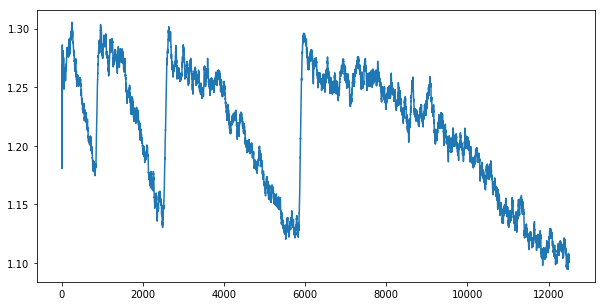

CPU times: user 44min 1s, sys: 11min 1s, total: 55min 3s
Wall time: 1h 17min 19s


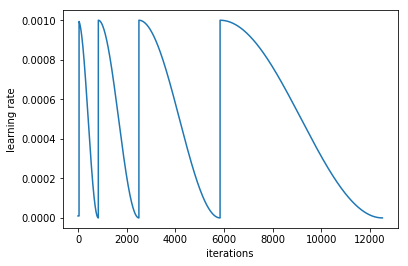

In [13]:
%%time
# Without weight decay
adam = Get_Adam()
loss_adam = experiment(adam, PATH, 1e-3)
save_list('adam_loss.txt', loss_adam)

In [14]:
%%time
# With weight decay
adamw = Get_Adam()
loss_adamw = experiment(adamw, PATH, 1e-3, use_wd_sched=True)
save_list('adamw_loss.txt', loss_adamw)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

[ 0.       1.0431   0.97478  0.66081]                       

Now with precompute as False


HBox(children=(IntProgress(value=0, description='Epoch', max=30), HTML(value='')))

[ 0.       1.05805  0.92621  0.67698]                       
[ 1.       0.99735  0.8888   0.688  ]                        
 95%|█████████▍| 396/417 [02:15<00:07,  2.93it/s, loss=1.05]

KeyboardInterrupt: 

### Differential Learning and Weight Decay

In [ ]:
%%time
adamw_diff = Get_Adam()
lr = 1e-3
wd = 0.025
loss_adamw_diff = experiment(adamw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True)
save_list('loss_adamw_diff.txt', loss_adamw_diff)

In [ ]:
%%time
sgdw_diff = Get_SGD_Momentum(0.9)
lr = 1e-2
wd = 0.025
loss_sgdw_diff = experiment(sgdw_diff, PATH, [lr/10, lr/5, lr], wds=[wd/10, wd/5, wd], use_wd_sched=True)
save_list('loss_sgdw_diff.txt', loss_sgdw_diff)

In [ ]:
fig=plt.figure(figsize=(15, 10))
plt.plot(loss_adam, c='red', label='Adam')
plt.plot(loss_sgdm, c='blue', label='SGDM')
plt.plot(loss_adamw, c='green', label='AdamW')
plt.plot(loss_sgdmw, c='black', label='SGDW')
plt.plot(loss_adamw_diff, c='orange', label='AdamW_differential')
plt.plot(loss_sgdw_diff, c='gray', label='SGDW_differential')
plt.legend()
plt.show()

### Section 2: Check for regularization of overfitting

In [ ]:
import time

In [ ]:
def check_overfitting(optimizer, PATH, sz, bs, lr, wds, use_wd_sched=True):
    
    arch=resnet50
    cycle_len=12
    cycle_mult=2
    num_cycles = 1

    tfms = tfms_from_model(arch, sz) # aug_tfms=transforms_side_on, max_zoom=1.1
    data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs)
    # Turning off Dropout, adding 3 extra FC layers to help in overfitting.
    learn = ConvLearner.pretrained(arch, data, precompute=False, xtra_fc=[1024, 512], ps=[0, 0, 0], opt_fn=optimizer)

    print("==== Let's overfit the model. Expectation: training loss should reduce but validation loss should stagnate.")
    learn.unfreeze()
    learn.fit(lr, num_cycles, cycle_len=cycle_len, cycle_mult=cycle_mult)
    print("==== Let's introduce weight regularization. Expectation: training loss and validation loss should reduce. Accuracy should improve.")
    learn.fit(lr, num_cycles, wds=wds, use_wd_sched=use_wd_sched,  cycle_len=cycle_len, cycle_mult=cycle_mult)
    time.sleep(5)

**AdamW on Cats & Dogs**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.dogscats/"
check_overfitting(Get_Adam(), PATH=PATH, sz=224, bs=96, lr=1e-3, wds=0.25, use_wd_sched=True)

**AdamW on Cifar10**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=True)

**Adam on Cifar10**

In [ ]:
%%time
PATH = "/home/as/datasets/fastai.cifar10/cifar10/"
check_overfitting(Get_Adam(), PATH=PATH, sz=32, bs=320, lr=1e-3, wds=0.45, use_wd_sched=False)